In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
#         dkl = - rho * torch.log(self.data_rho) - (1 - rho) * torch.log(1 - self.data_rho)
        dkl = torch.abs(self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [7]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data.to(device))
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data.to(device)) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [9]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
data_rho_lambda = lambda q: 'data_rho: {}'.format(q)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
line_extra = lambda i, l, p, q: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p) + '\n' + data_rho_lambda(q)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data.to(device)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data.to(device), reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k], models[k].data_rho))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.976201 32: 1.004787 64: 0.992407
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.916889 32: 0.916274 64: 0.794169
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.878179 32: 0.780130 64: 0.381216
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.838408 32: 0.562025 64: 0.283667
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.736219 32: 0.431168 64: 0.255085
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.594981 32: 0.355852 64: 0.225789
Test set:
16: loss: 0.5892	rho_loss: 0.0028
32: loss: 0.3519	rho_loss: 0.0038
64: loss: 0.2243	rho_loss: 0.0037

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.588390 32: 0.360928 64: 0.237498
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.502608 32: 0.303989 64: 0.201412
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.444309 32: 0.267029 64: 0.182527
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.391897 32: 0.240951 64: 0.176713
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.376594 32: 0.242948 64: 0.175628
Train

Test set:
16: loss: 0.1253	rho_loss: 0.0013
32: loss: 0.0758	rho_loss: 0.0014
64: loss: 0.0402	rho_loss: 0.0013

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.131592 32: 0.079572 64: 0.041080
Train Epoch: 15 [10000/50000 (20%)]	Losses 16: 0.128310 32: 0.078747 64: 0.041854
Train Epoch: 15 [20000/50000 (40%)]	Losses 16: 0.135076 32: 0.078338 64: 0.042219
Train Epoch: 15 [30000/50000 (60%)]	Losses 16: 0.119047 32: 0.069642 64: 0.037472
Train Epoch: 15 [40000/50000 (80%)]	Losses 16: 0.116209 32: 0.067929 64: 0.036707
Train Epoch: 15 [50000/50000 (100%)]	Losses 16: 0.136937 32: 0.084792 64: 0.044537
Test set:
16: loss: 0.1220	rho_loss: 0.0013
32: loss: 0.0750	rho_loss: 0.0014
64: loss: 0.0403	rho_loss: 0.0013

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.124551 32: 0.077452 64: 0.042400
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.123922 32: 0.068124 64: 0.036181
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.117909 32: 0.069389 64: 0.037304
Train Epoch: 16 [30000/50000 (60%)]	Losses 16

In [11]:
data, _ = next(iter(test_loader))
output = models['64'](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models['64'].decode(torch.eye(64).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28).to(device))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([ 2,  5,  1,  6,  4,  3,  3,  6,  8,  5,  7,  8,  2,  3,  2,  8,  4,  6,
         3,  2,  4,  6,  3,  5,  2, 12,  1,  3,  5,  3,  6,  3,  3,  5,  6,  5,
         2,  2,  5,  2,  1,  4,  3,  4,  7,  3,  7,  4,  4,  3],
       device='cuda:0')


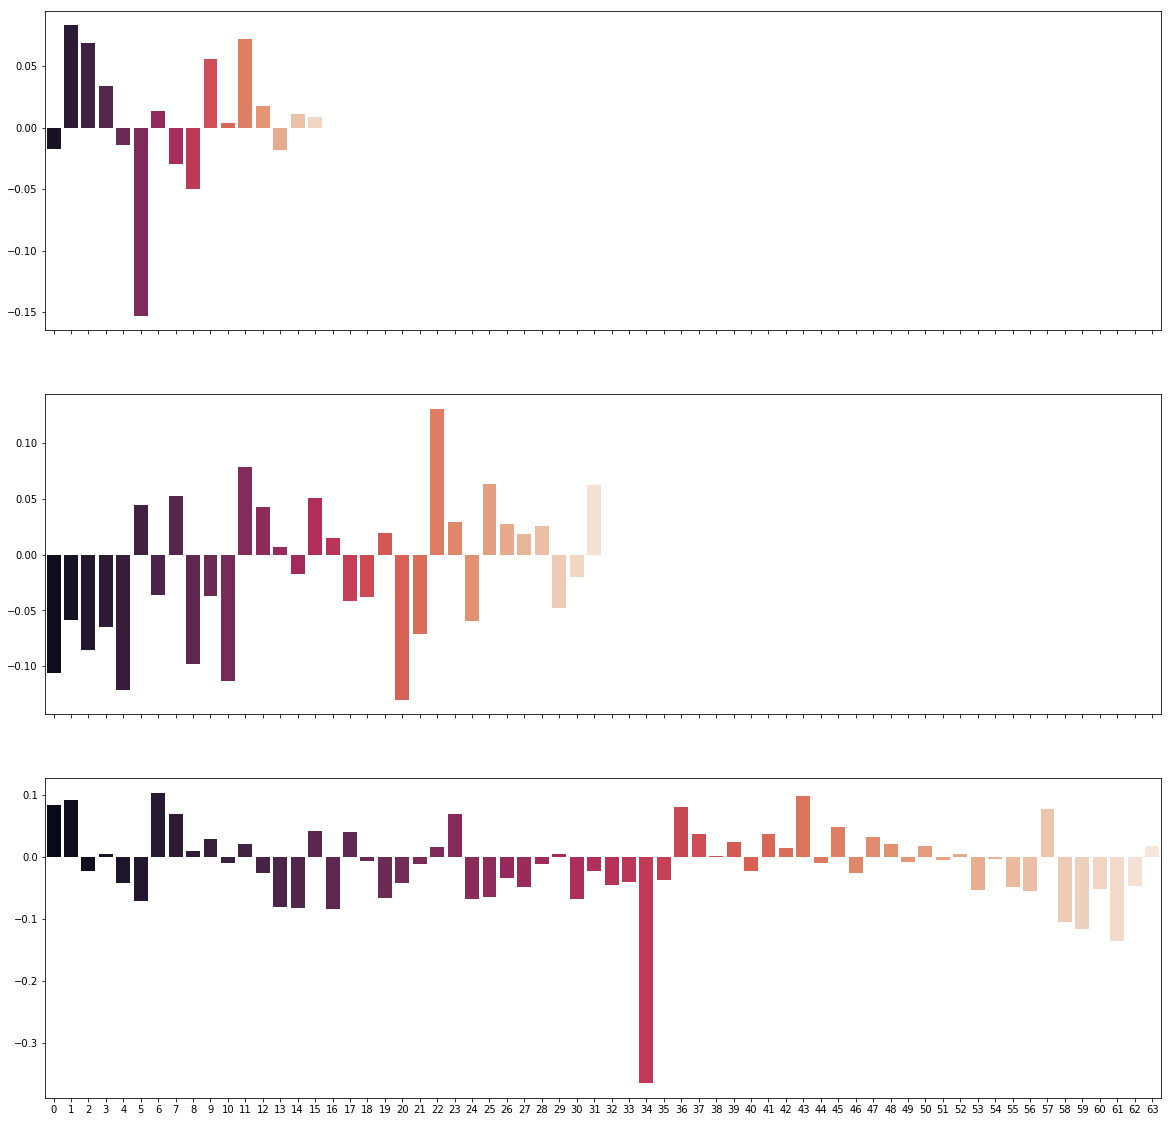

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharex=True)
i = 19
sns.barplot(np.arange(16), test_log['16'][i][2].cpu().numpy(), palette="rocket", ax=ax1)
sns.barplot(np.arange(32), test_log['32'][i][2].cpu().numpy(), palette="rocket", ax=ax2)
sns.barplot(np.arange(64), test_log['64'][i][2].cpu().numpy(), palette="rocket", ax=ax3)

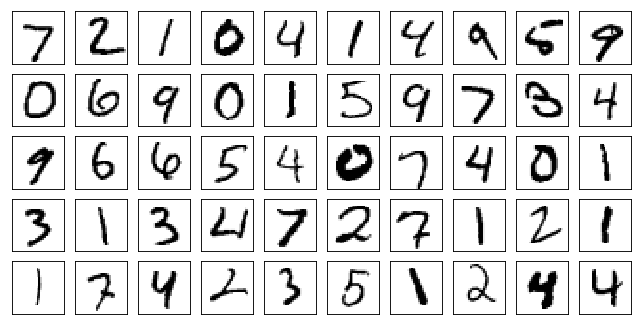

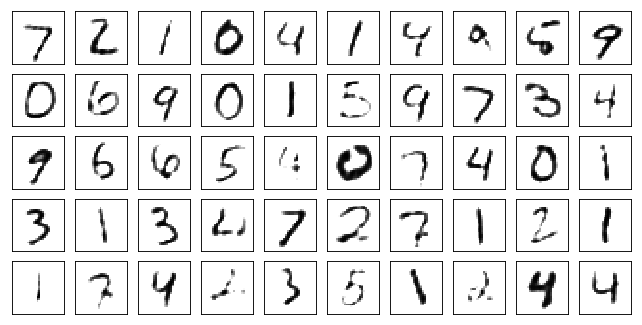

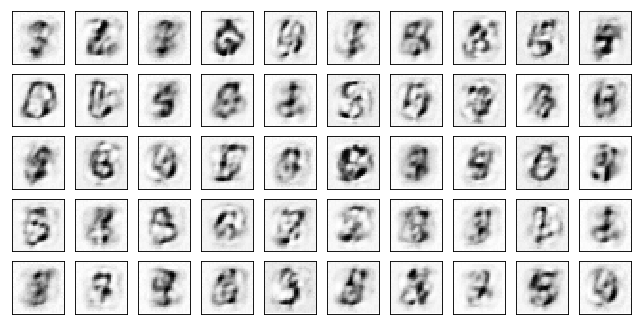

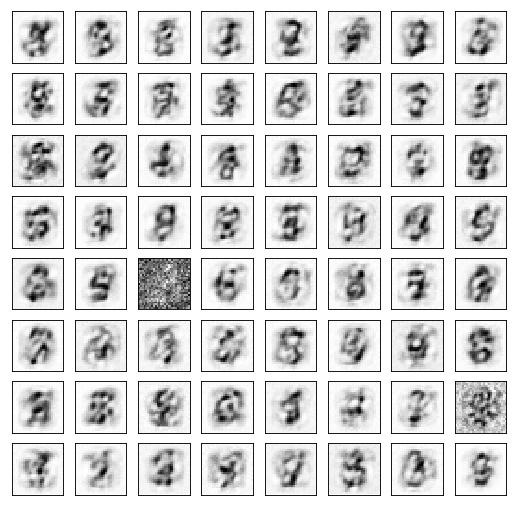

In [13]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))